In [1]:
# --- CRITICAL FIX: Set Environment Variable ---
import os
os.environ['TF_USE_LEGACY_KERAS'] = '1'
# ---------------------------------------------

import re
import pandas as pd
import tensorflow as tf
import tf_keras # Import the new Keras package
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification, AutoConfig
from huggingface_hub import hf_hub_download
import warnings
from google.colab import drive, files

# Suppress warnings
warnings.filterwarnings("ignore", category=UserWarning)

print(f"Using TensorFlow version: {tf.__version__}")
import transformers
print(f"Using Transformers version: {transformers.__version__}")

# --- 1. Mount Drive ---
print("\nMounting Google Drive...")
drive.mount('/content/drive')

# --- 2. Upload CSV ---
print("\nPlease upload your 'total_df.csv' file:")
uploaded_csv = files.upload()
total_df_path = list(uploaded_csv.keys())[0]

# --- 3. Set Paths ---
dataset_path = "/content/drive/MyDrive/DAICWOZ_MAIN"
model_name = "distilbert-base-uncased"
print(f"\nCSV path set to: {total_df_path}")
print(f"Dataset path set to: {dataset_path}")

# --- 4. VITAL CHECK ---
print("\nChecking for data at Drive path:")
!ls -l "{dataset_path}" | head -n 10

Using TensorFlow version: 2.19.0
Using Transformers version: 4.57.1

Mounting Google Drive...
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).

Please upload your 'total_df.csv' file:


Saving total_df.csv to total_df (5).csv

CSV path set to: total_df (5).csv
Dataset path set to: /content/drive/MyDrive/DAICWOZ_MAIN

Checking for data at Drive path:
total 760
drwx------ 2 root root 4096 Oct 22 13:47 300_P
drwx------ 2 root root 4096 Oct 22 13:47 301_P
drwx------ 2 root root 4096 Oct 22 13:47 302_P
drwx------ 2 root root 4096 Oct 22 13:47 303_P
drwx------ 2 root root 4096 Oct 22 13:47 304_P
drwx------ 2 root root 4096 Oct 22 13:47 305_P
drwx------ 2 root root 4096 Oct 22 13:47 306_P
drwx------ 2 root root 4096 Oct 22 13:47 307_P
drwx------ 2 root root 4096 Oct 22 13:47 308_P


In [2]:
def parse_daicwoz_transcript(filepath):
    """
    Parses the DAIC-WOZ transcript file.
    """
    with open(filepath, 'r', encoding='utf-8') as f:
        lines = f.readlines()

    header = ['start_time', 'stop_time', 'speaker', 'value']
    rows = []
    for line in lines[1:]:  # Skip header row in file
        try:
            line_split = re.split(r'\t| {2,}', line.strip())
            if len(line_split) == 4:
                rows.append(line_split)
            elif len(line_split) > 4:
                rows.append(line_split[:3] + [' '.join(line_split[3:])])
            else:
                line_split_alt = re.split(r'\s+', line.strip())
                if len(line_split_alt) >= 4:
                    rows.append(line_split_alt[:4])
        except Exception as e:
            print(f"Skipping line in {filepath} due to error: {e}. Line: {line}")

    df = pd.DataFrame(rows, columns=header)
    return df

def load_all_transcripts(parent_dir):
    """
    Iterates through all session folders, parses transcripts,
    and extracts only 'Participant' text.
    """
    print(f"Loading all transcripts from: {parent_dir}")
    texts, participant_ids = [], []

    if not os.path.exists(parent_dir):
        print(f"ERROR: The directory '{parent_dir}' does not exist.")
        return pd.DataFrame()

    session_list = [f for f in os.listdir(parent_dir) if os.path.isdir(os.path.join(parent_dir, f)) and f.endswith('_P')]

    for session_folder in session_list:
        session_path = os.path.join(parent_dir, session_folder)
        participant_id = session_folder.split('_')[0]

        try:
            transcript_file_name = [f for f in os.listdir(session_path) if 'TRANSCRIPT' in f and f.endswith('.csv')][0]
            transcript_filepath = os.path.join(session_path, transcript_file_name)
        except IndexError:
            print(f"Warning: No '...TRANSCRIPT.csv' file found in {session_folder}. Skipping.")
            continue

        try:
            df_t = parse_daicwoz_transcript(transcript_filepath)
            utterances = df_t[df_t['speaker'].str.strip().str.lower() == 'participant']['value'].dropna().astype(str).tolist()

            if not utterances:
                print(f"Warning: No participant utterances found for {participant_id}. Skipping.")
                continue

            full_text = " ".join(utterances)
            texts.append(full_text)
            participant_ids.append(participant_id)

        except Exception as e:
            print(f"Error parsing transcript for {participant_id}: {e}")

    print(f"Successfully loaded and processed {len(texts)} transcripts.")
    return pd.DataFrame({
        "participant_id": participant_ids,
        "text": texts
    })

# --- Execute Data Loading ---
text_df = load_all_transcripts(dataset_path)

if not text_df.empty:
    print(f"Loading labels from {total_df_path}...")

    labels_df = pd.read_csv(total_df_path)

    print(f"Merging {len(text_df)} transcripts with {len(labels_df)} labels.")
    text_df['participant_id'] = text_df['participant_id'].astype(str)
    labels_df['Participant_ID'] = labels_df['Participant_ID'].astype(str)

    df = pd.merge(text_df, labels_df, left_on='participant_id', right_on='Participant_ID')

    df = df[['participant_id', 'text', 'PHQ8_Binary']]
    df = df.rename(columns={'PHQ8_Binary': 'label'})
    df = df.dropna(subset=['label'])
    df['label'] = df['label'].astype(int)

    print("\nData loading complete. DataFrame head:")
    print(df.head())
    print(f"\nTotal records loaded: {len(df)}")
    print("\nData distribution:")
    print(df['label'].value_counts())
else:
    print("Data loading failed. Please check your path in Step 3.")

Loading all transcripts from: /content/drive/MyDrive/DAICWOZ_MAIN
Successfully loaded and processed 189 transcripts.
Loading labels from total_df (5).csv...
Merging 189 transcripts with 189 labels.

Data loading complete. DataFrame head:
  participant_id                                               text  label
0            407  <sync> yes <clears throat> i'm actually feel <...      0
1            400  <synch> yeah i'm fine um pacific grove califor...      0
2            393  <sync> yes i'm good i'm originally from los an...      0
3            408  <sync> yes i am i'm doing great i am originall...      0
4            391  <sync> yes kind of down i don't have a boyfrie...      0

Total records loaded: 189

Data distribution:
label
0    133
1     56
Name: count, dtype: int64


In [6]:
# --- We need to import the EarlyStopping callback ---
from tf_keras.callbacks import EarlyStopping
# ---------------------------------------------------

print("\nPreprocessing data...")
# Split the data
train_texts, test_texts, train_labels, test_labels = train_test_split(
    df["text"].tolist(),
    df["label"].tolist(),
    test_size=0.2,
    stratify=df["label"],
    random_state=42
)

# Initialize tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Tokenize the text
train_enc = tokenizer(train_texts, truncation=True, padding=True, max_length=256)
test_enc = tokenizer(test_texts, truncation=True, padding=True, max_length=256)

# Create TensorFlow datasets
train_ds = tf.data.Dataset.from_tensor_slices((dict(train_enc), train_labels)).shuffle(1000).batch(8)
test_ds = tf.data.Dataset.from_tensor_slices((dict(test_enc), test_labels)).batch(8)
print("Data preprocessing complete.")

print("\nBuilding and training model...")

# --- (This model loading is the same as before) ---
print("Loading model config...")
config = AutoConfig.from_pretrained(model_name, num_labels=2)
print("Creating model from config...")
model = TFAutoModelForSequenceClassification.from_config(config)
print("Downloading TensorFlow weights...")
weights_path = hf_hub_download(repo_id=model_name, filename="tf_model.h5")
print("Building model variables...")
dummy_input = {
    'input_ids': tf.zeros((8, 256), dtype=tf.int32),
    'attention_mask': tf.zeros((8, 256), dtype=tf.int32)
}
_ = model(dummy_input)
print("Model variables built.")
print(f"Loading weights from {weights_path}...")
model.load_weights(weights_path, by_name=True, skip_mismatch=True)
print("Model loaded successfully.")
# ----------------------------------------

optimizer = tf_keras.optimizers.Adam(learning_rate=3e-5)
loss_fn = tf_keras.losses.SparseCategoricalCrossentropy(from_logits=True)
acc_metric = tf_keras.metrics.SparseCategoricalAccuracy(name="accuracy")

model.compile(optimizer=optimizer, loss=loss_fn, metrics=[acc_metric])

# --- NEW: Define the EarlyStopping callback ---
# This will:
# 1. Watch the validation loss
# 2. Stop if it doesn't improve for 1 epoch (patience=1)
# 3. Automatically restore the weights from the best epoch
early_stopping_callback = EarlyStopping(
    monitor='val_loss',
    patience=2,
    restore_best_weights=True
)
# -----------------------------------------------

# We can set epochs higher, EarlyStopping will handle it
epochs = 10

history = model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=epochs,
    # --- NEW: Pass the callback to the model ---
    callbacks=[early_stopping_callback]
    # ------------------------------------------
)

print("Model training complete.")


Preprocessing data...
Data preprocessing complete.

Building and training model...
Loading model config...
Creating model from config...
Building model variables...
Model variables built.
Loading weights from /root/.cache/huggingface/hub/models--distilbert-base-uncased/snapshots/12040accade4e8a0f71eabdb258fecc2e7e948be/tf_model.h5...
Model loaded successfully.
Epoch 1/10
19/19 [==============================] - 331s 16s/step - loss: 0.6338 - accuracy: 0.6821 - val_loss: 0.6022 - val_accuracy: 0.7105
Epoch 2/10
19/19 [==============================] - 281s 14s/step - loss: 0.6205 - accuracy: 0.7020 - val_loss: 0.6067 - val_accuracy: 0.7105
Epoch 3/10
19/19 [==============================] - 256s 13s/step - loss: 0.6107 - accuracy: 0.7020 - val_loss: 0.6053 - val_accuracy: 0.7105
Model training complete.


In [8]:
model.summary()

Model: "tf_distil_bert_for_sequence_classification_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 distilbert (TFDistilBertMa  multiple                  66362880  
 inLayer)                                                        
                                                                 
 pre_classifier (Dense)      multiple                  590592    
                                                                 
 classifier (Dense)          multiple                  1538      
                                                                 
 dropout_39 (Dropout)        multiple                  0         
                                                                 
Total params: 66955010 (255.41 MB)
Trainable params: 66955010 (255.41 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________



--- Model Performance ---
Evaluating model on the test set...
5/5 [==============================] - 20s 4s/step - loss: 0.6022 - accuracy: 0.7105
Test Loss: 0.6022
Test Accuracy: 0.7105


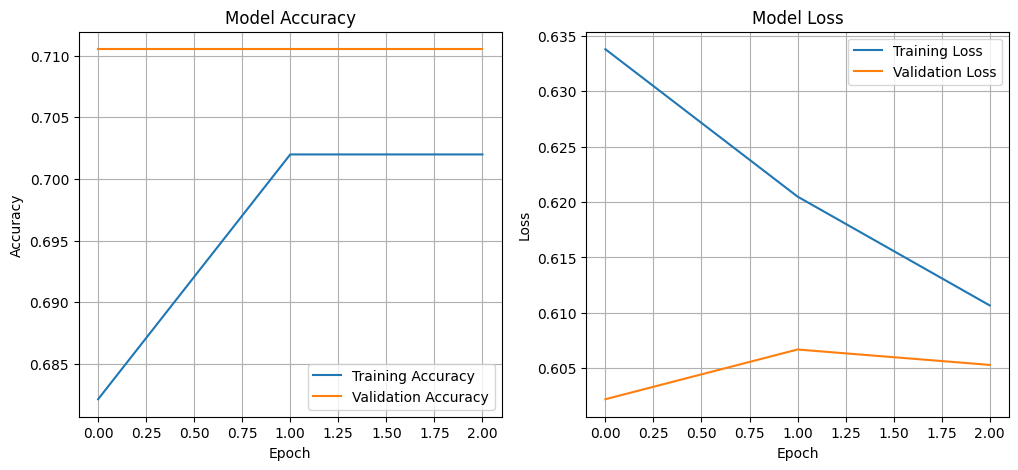


--- Test Set Classification Report ---
5/5 [==============================] - 21s 4s/step
                    precision    recall  f1-score   support

NO (Not Depressed)       0.71      1.00      0.83        27
   YES (Depressed)       0.00      0.00      0.00        11

          accuracy                           0.71        38
         macro avg       0.36      0.50      0.42        38
      weighted avg       0.50      0.71      0.59        38

--- Confusion Matrix ---


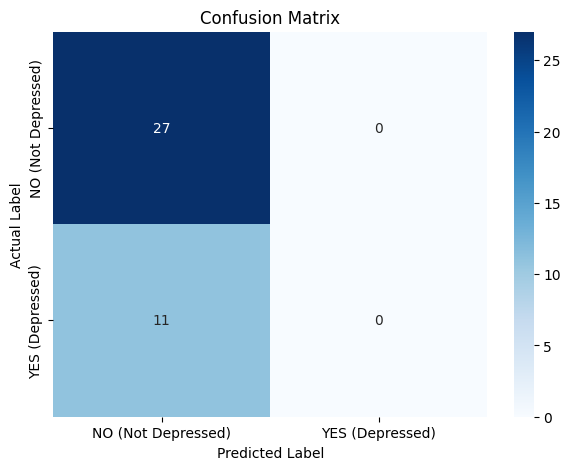

In [7]:
# --- We'll import seaborn here, right where we need it ---
import seaborn as sns
# --------------------------------------------------------

print("\n--- Model Performance ---")

# --- 1. Explicitly evaluate on the test set ---
print("Evaluating model on the test set...")
test_results = model.evaluate(test_ds)
print(f"Test Loss: {test_results[0]:.4f}")
print(f"Test Accuracy: {test_results[1]:.4f}")
# ----------------------------------------------

# --- 2. Plot Training & Validation Accuracy/Loss ---
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.grid(True)
plt.show()

# --- 3. Get Classification Report ---
print("\n--- Test Set Classification Report ---")
predictions = model.predict(test_ds)
y_pred = np.argmax(tf.nn.softmax(predictions.logits, axis=-1), axis=1)
y_true = np.concatenate([y for x, y in test_ds], axis=0)

target_names = ['NO (Not Depressed)', 'YES (Depressed)']
print(classification_report(y_true, y_pred, target_names=target_names))

# --- 4. NEW: Plot Confusion Matrix with Seaborn ---
print("--- Confusion Matrix ---")
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(7, 5))
sns.heatmap(cm,
            annot=True, # Show numbers in the squares
            fmt='d', # Format as integers
            cmap='Blues', # Color scheme
            xticklabels=target_names,
            yticklabels=target_names)
plt.title('Confusion Matrix')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

In [13]:
# Define a path to save the model
save_directory = "/content/my_depression_model"

# Save the model and tokenizer
model.save_pretrained(save_directory)
tokenizer.save_pretrained(save_directory)

print(f"Model saved to {save_directory}")

# Zip the model for easy download
!zip -r /content/my_depression_model.zip /content/my_depression_model

print("\nModel zipped. You can download 'my_depression_model.zip' from the file panel on the left.")

Model saved to /content/my_depression_model
  adding: content/my_depression_model/ (stored 0%)
  adding: content/my_depression_model/tokenizer.json (deflated 82%)
  adding: content/my_depression_model/config.json (deflated 49%)
  adding: content/my_depression_model/merges.txt (deflated 53%)
  adding: content/my_depression_model/tf_model.h5 (deflated 8%)
  adding: content/my_depression_model/vocab.json (deflated 59%)
  adding: content/my_depression_model/tokenizer_config.json (deflated 75%)
  adding: content/my_depression_model/special_tokens_map.json (deflated 52%)

Model zipped. You can download 'my_depression_model.zip' from the file panel on the left.
